# CNN 1D IA - Detección de apnea del sueño 

In [14]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\lauri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [24]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)


## Carga de archivos .csv desde carpetas y etiquetarlos

In [16]:
# Ruta base donde están las carpetas
ruta_filtrados = r'C:\Users\lauri\Documents\Semestre_9\Int_IA\Filtrados_por_Canales'

# Canales esperados
canales_deseados = ['X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2']
forma_deseada = (375, 6)  # por ejemplo

# Inicializar listas para datos y etiquetas
X = []
y = []

# Función para cargar los archivos de una carpeta
def cargar_archivos(ruta_carpeta, etiqueta):
    for archivo in glob.glob(os.path.join(ruta_carpeta, '*.csv')):
        try:
            df = pd.read_csv(archivo)
            columnas = list(df.columns)  # Ignorar la primera columna si no es un canal

            if columnas == canales_deseados:
                datos = df.iloc[:, :].values  # Tomar solo las columnas de canales
                if datos.shape == forma_deseada:
                    X.append(datos)
                    y.append(etiqueta)
                else:
                    print(f"⚠️ Forma no válida en: {archivo} -> {datos.shape}")
            else:
                print(f"⚠️ Columnas incorrectas en: {archivo} -> {columnas}")
        except Exception as e:
            print(f"❌ Error en archivo {archivo}: {e}")

# Cargar eventos (etiqueta = 1)
cargar_archivos(os.path.join(ruta_filtrados, 'Eventos'), etiqueta=1)

# Cargar no eventos (etiqueta = 0)
cargar_archivos(os.path.join(ruta_filtrados, 'No_eventos'), etiqueta=0)

# Convertir a NumPy
X = np.array(X)
y = np.array(y)

# Verificar formas
print(f"✅ Datos cargados: X.shape = {X.shape}, y.shape = {y.shape}")


✅ Datos cargados: X.shape = (910, 375, 6), y.shape = (910,)


In [17]:
X = np.array(X).astype('float32')  # (n_samples, 376, 6)
y = np.array(y).astype('float32')  # (n_samples,)

# Normalización por muestra (media 0, varianza 1)
n_muestras, n_tiempo, n_canales = X.shape

# Aplanar para aplicar StandardScaler (cada muestra: 375*5 = 1875)
X_flat = X.reshape(n_muestras, -1)  # (n_muestras, 1875)

# Normalizar
scaler = StandardScaler()
X_norm_flat = scaler.fit_transform(X_flat)

# Restaurar la forma original
X_norm = X_norm_flat.reshape(n_muestras, n_tiempo, n_canales)

print("Normalización completa. X_norm.shape =", X_norm.shape)

Normalización completa. X_norm.shape = (910, 375, 6)


## Definir datos de prueba y entrenamiento

In [18]:
print(f"Total de muestras: {len(y)}")
y

Total de muestras: 910


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [32]:
# División 70% entrenamiento, 30% test
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=40)

print("Entrenamiento:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

# Conteo de clases en entrenamiento
clases_entrenamiento, conteo_entrenamiento = np.unique(y_train, return_counts=True)
print("\n📊 Distribución en entrenamiento:")
for clase, cantidad in zip(clases_entrenamiento, conteo_entrenamiento):
    nombre = "No Evento" if clase == 0 else "Evento"
    print(f"{nombre} ({clase}): {cantidad}")

# Conteo de clases en test
clases_test, conteo_test = np.unique(y_test, return_counts=True)
print("\n📊 Distribución en test:")
for clase, cantidad in zip(clases_test, conteo_test):
    nombre = "No Evento" if clase == 0 else "Evento"
    print(f"{nombre} ({clase}): {cantidad}")


Entrenamiento: (637, 375, 6) (637,)
Test: (273, 375, 6) (273,)

📊 Distribución en entrenamiento:
No Evento (0.0): 322
Evento (1.0): 315

📊 Distribución en test:
No Evento (0.0): 134
Evento (1.0): 139


## Definir modelo

In [33]:
# Modelo CNN 1D
modelo = Sequential([
    Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(375, 6)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binaria (0 o 1)
])

# Compilar
modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen
modelo.summary()

C:\Users\lauri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 371, 32)        │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 371, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 185, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 183, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 183, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 91, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 5824)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       372,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,449 (1.45 MB)

 Trainable params: 380,257 (1.45 MB)

 Non-trainable params: 192 (768.00 B)

## Entrenamiento 

In [34]:
# Entrenamiento
hist = modelo.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6079 - loss: 1.0246 - val_accuracy: 0.6300 - val_loss: 0.6419
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8616 - loss: 0.4233 - val_accuracy: 0.6996 - val_loss: 0.5776
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9268 - loss: 0.1820 - val_accuracy: 0.7509 - val_loss: 0.5205
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9595 - loss: 0.1052 - val_accuracy: 0.7619 - val_loss: 0.5045
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9916 - loss: 0.0609 - val_accuracy: 0.7289 - val_loss: 0.5412
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9927 - loss: 0.0430 - val_accuracy: 0.7473 - val_loss: 0.5426
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9847 - loss: 0.0398 - val_accuracy: 0.7692 - val_loss: 0.5191
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9921 - loss: 0.0277 - val_accuracy: 0.7839 - v

# Evaluación del modelo

In [35]:
# Evaluación en test
loss, acc = modelo.evaluate(X_test, y_test)
print(f"Precisión en test: {acc:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8777 - loss: 0.5736 
Precisión en test: 0.8278


## Matrices de confusión


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


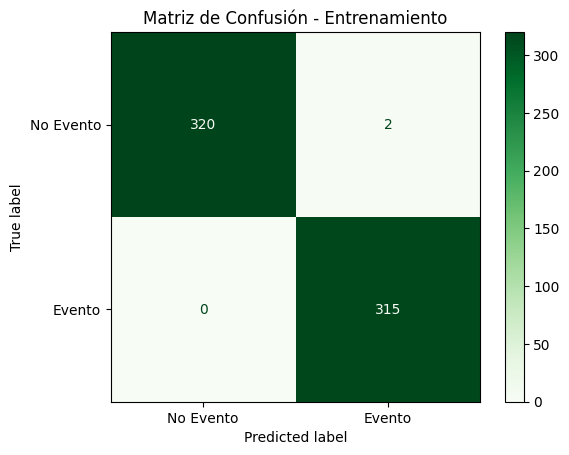

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


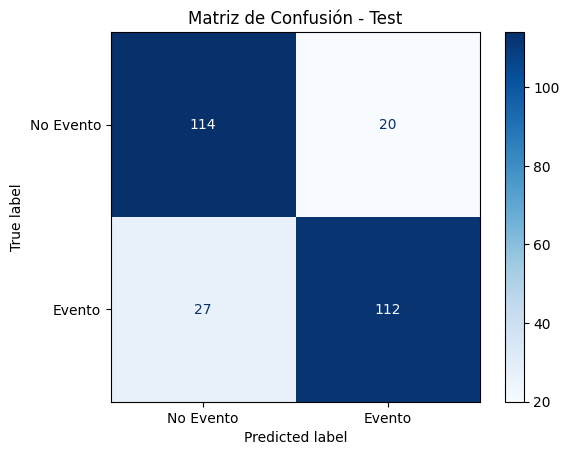

In [36]:
# Función general para mostrar matriz de confusión
def mostrar_matriz_confusion(y_true, y_pred, titulo, cmap):
    # Detectar las etiquetas presentes
    etiquetas_presentes = np.unique(np.concatenate([y_true, y_pred]))

    # Calcular matriz de confusión solo con las etiquetas presentes
    cm = confusion_matrix(y_true, y_pred, labels=etiquetas_presentes)

    # Etiquetas de texto (0 = No Evento, 1 = Evento)
    etiquetas_texto = ["No Evento", "Evento"]
    etiquetas_uso = [etiquetas_texto[int(i)] for i in etiquetas_presentes]

    # Mostrar
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=etiquetas_uso)
    disp.plot(cmap=cmap)
    plt.title(titulo)
    plt.show()

# ----------------------------
# --- Matriz de entrenamiento
# ----------------------------
y_train_pred_proba = modelo.predict(X_train)
y_train_pred = (y_train_pred_proba > 0.5).astype(int).flatten()

mostrar_matriz_confusion(
    y_train,
    y_train_pred,
    "Matriz de Confusión - Entrenamiento",
    cmap=plt.cm.Greens
)

# ----------------------------
# --- Matriz de prueba
# ----------------------------
y_test_pred_proba = modelo.predict(X_test)
y_test_pred = (y_test_pred_proba > 0.5).astype(int).flatten()

mostrar_matriz_confusion(
    y_test,
    y_test_pred,
    "Matriz de Confusión - Test",
    cmap=plt.cm.Blues
)


In [38]:
# --- Predecir y mostrar métricas
# y_true = y_test
# y_pred = (modelo.predict(X_test) > 0.5).astype(int).flatten()

def mostrar_metricas_completas(y_true, y_pred):
    print("📊 Reporte completo:\n")
    reporte = classification_report(
        y_true, y_pred, target_names=["No Evento", "Evento"], output_dict=True, zero_division=0
    )

    # Métricas por clase
    print(f"{'Métrica':<15} {'No Evento':>10} {'Evento':>10}")
    for metrica in ['precision', 'recall', 'f1-score', 'support']:
        print(f"{metrica:<15} {reporte['No Evento'][metrica]:>10.3f} {reporte['Evento'][metrica]:>10.3f}")

    # Métricas globales
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision_w = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_w = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)

    print("\n🌐 Métricas Globales:")
    print(f"{'Precision-W':<15}: {precision_w:.3f}")
    print(f"{'Recall-W':<15}: {recall_w:.3f}")
    print(f"{'F1-score (W)':<15}: {f1_weighted:.3f}")
    print(f"{'F1-score (AVG)':<15}: {f1_macro:.3f}")
    print(f"{'Accuracy':<15}: {accuracy:.3f}")
    print(f"{'Kaggle sc (F1 AVG)':<15}: {f1_macro:.3f}")  # Puedes ajustar si es otra métrica

# --- Predecir
y_pred = (modelo.predict(X_test) > 0.5).astype(int).flatten()

# --- Mostrar métricas
mostrar_metricas_completas(y_test, y_pred)

# --- Predecir
y_pred = (modelo.predict(X_train) > 0.5).astype(int).flatten()

# --- Mostrar métricas
mostrar_metricas_completas(y_train, y_pred)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
📊 Reporte completo:

Métrica          No Evento     Evento
precision            0.809      0.848
recall               0.851      0.806
f1-score             0.829      0.827
support            134.000    139.000

🌐 Métricas Globales:
Precision-W    : 0.829
Recall-W       : 0.828
F1-score (W)   : 0.828
F1-score (AVG) : 0.828
Accuracy       : 0.828
Kaggle sc (F1 AVG): 0.828
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
📊 Reporte completo:

Métrica          No Evento     Evento
precision            1.000      0.994
recall               0.994      1.000
f1-score             0.997      0.997
support            322.000    315.000

🌐 Métricas Globales:
Precision-W    : 0.997
Recall-W       : 0.997
F1-score (W)   : 0.997
F1-score (AVG) : 0.997
Accuracy       : 0.997
Kaggle sc (F1 AVG): 0.997
